In [1]:
import pandas as pd
import numpy as np

In [2]:

import torch

In [114]:
df = pd.read_csv('macro_index_returns.csv')

In [36]:
df = pd.read_csv("EB_sampled.csv")

In [ ]:
df = pd.read_csv("bootstraped_macro.csv")

In [116]:
def clean_date_csv(df):
    df = df.copy()  # optional: avoid modifying original
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
        df.index = pd.to_datetime(df.index)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.reset_index(drop=True)
    if "date" in df.columns:
      df = df.drop(columns=["date"])
    return df

In [117]:
cleaned_df = clean_date_csv(df)

In [118]:
cleaned_df

TICKER,GLD,IEF,SPY,USO,UUP
0,0.029105,0.007126,-0.008755,0.035771,-0.008861
1,0.008367,0.002054,-0.000483,-0.001274,0.002129
2,-0.005142,0.002619,-0.024506,-0.013526,-0.010620
3,-0.004229,0.001817,-0.000849,-0.023412,0.009875
4,0.023711,0.002100,-0.016148,0.007417,-0.001276
...,...,...,...,...,...
4274,0.001992,0.000542,0.011115,0.008076,0.002731
4275,0.006751,0.000759,0.000067,-0.007060,-0.002043
4276,-0.006871,-0.002600,-0.010527,0.009845,-0.001706
4277,-0.003190,0.005864,-0.011412,0.013135,0.001025


raw data cleaning

In [115]:
def raw_data_clean(df):
  columns = ["RETX", "date","TICKER"]
  df = df[columns]

  def convert_to_number(x):
      try:
          return float(x)
      except:
          return None

  df['ret_parsed'] = df['RETX'].apply(convert_to_number)

  df["date"] = pd.to_datetime(df["date"])
  df = df.set_index("date")
  df = df.drop(columns=["RETX"])

  df = df.pivot_table(index=df.index, columns="TICKER", values="ret_parsed", aggfunc="first")

  df = df.dropna()
  return df

df = raw_data_clean(df)

/tmp/ipython-input-1184919607.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ret_parsed'] = df['RETX'].apply(convert_to_number)
/tmp/ipython-input-1184919607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


In [40]:
raw_returns = cleaned_df

In [119]:
# 2. Compute stable rolling z
def safe_rolling_zscore(df, window):
    rolling_mean = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()

    # If std == 0 → return 0 instead of NaN or inf
    z = (df - rolling_mean) / rolling_std.replace(0, np.nan)
    z = z.fillna(0)

    return z

normalized_returns = safe_rolling_zscore(raw_returns, window=60)

# 3. Replace infinities / residual NaN
normalized_returns_df = normalized_returns.replace([np.inf, -np.inf], 0)

In [120]:
rolling_vol_df  =cleaned_df.rolling(60).std() * np.sqrt(252)

In [121]:
rolling_vol_df = rolling_vol_df[60:]

In [122]:
raw_returns, rolling_vol_df = raw_returns.align(rolling_vol_df, join='inner')
normalized_returns, rolling_vol_df = normalized_returns.align(rolling_vol_df, join='inner')


In [123]:
print(len(normalized_returns))
print(len(raw_returns))
print(len(rolling_vol_df))

4219
4219
4219


training section

In [124]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Suppose normalized_returns, raw_returns, rolling_vol_df have same index
T = len(normalized_returns)

# ---------------------------
# Train / Val / Test Split
# ---------------------------

train_ratio = 0.8
val_ratio   = 0.16      # 20% of the total 80% train block (i.e., 16% of total)
test_ratio  = 0.20

train_end = int(T * (1 - test_ratio))         # first 80%
val_end   = int(train_end * (1 - 0.20))       # carve out 20% of train

# Alternatively:
# val_end = int(T * 0.64)   # 64% = 80% * 80%

# ---------------------------
# Slices: 0 → val → test
# ---------------------------
normalized_returns_train = normalized_returns.iloc[:val_end]
normalized_returns_val   = normalized_returns.iloc[val_end:train_end]
normalized_returns_test  = normalized_returns.iloc[train_end:]

raw_returns_train = raw_returns.iloc[:val_end]
raw_returns_val   = raw_returns.iloc[val_end:train_end]
raw_returns_test  = raw_returns.iloc[train_end:]

vol_train = rolling_vol_df.iloc[:val_end]
vol_val   = rolling_vol_df.iloc[val_end:train_end]
vol_test  = rolling_vol_df.iloc[train_end:]

print("Train:", len(normalized_returns_train))
print("Val:  ", len(normalized_returns_val))
print("Test: ", len(normalized_returns_test))



Train: 2700
Val:   675
Test:  844


In [125]:
import numpy as np

window = 20  # past days

def build_panel_data(raw_returns,normalized_returns, vol, window):
    X_list, vol_list, y_list = [], [], []

    # returns: (T_train, 5)
    for t in range(window, len(raw_returns) - 1):
        # past window of returns: (window, 5)
        past_ret = normalized_returns.iloc[t-window:t].values    # (20, 5)
        # For Conv1d: (channels, seq_len) = (5, 20)
        panel = past_ret.T.astype(np.float32)         # (5, 20)

        X_list.append(panel)
        vol_list.append(vol.iloc[t].values.astype(np.float32))      # (5,)
        y_list.append(raw_returns.iloc[t].values.astype(np.float32))  # (5,)

    X = np.stack(X_list, axis=0)          # (N, 5, 20)
    vol_arr = np.stack(vol_list, axis=0)  # (N, 5)
    y = np.stack(y_list, axis=0)          # (N, 5)
    return X, vol_arr, y

X_train, vol_train_arr, y_train = build_panel_data(raw_returns_train, normalized_returns_train, vol_train, window)
X_val, vol_val_arr, y_val = build_panel_data(raw_returns_val, normalized_returns_val, vol_val, window)
X_test,  vol_test_arr,  y_test  = build_panel_data(raw_returns_test, normalized_returns_test, vol_test,  window)




In [126]:
class MacroPortfolioDataset(Dataset):
    def __init__(self, X, vol, y):
        self.X = torch.from_numpy(X)      # (N, D)
        self.vol = torch.from_numpy(vol)  # (N, 5)
        self.y = torch.from_numpy(y)      # (N, 5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vol[idx], self.y[idx]


In [127]:
import torch
from torch.utils.data import Dataset, DataLoader

class MacroPanelDataset(Dataset):
    def __init__(self, X, vol, y):
        self.X   = torch.from_numpy(X)      # (N, 5, 20)
        self.vol = torch.from_numpy(vol)    # (N, 5)
        self.y   = torch.from_numpy(y)      # (N, 5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vol[idx], self.y[idx]

train_dataset = MacroPanelDataset(X_train, vol_train_arr, y_train)
val_dataset   = MacroPanelDataset(X_val,   vol_val_arr,   y_val)
test_dataset  = MacroPanelDataset(X_test,  vol_test_arr,  y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)




In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MacroCNNNet(nn.Module):
    def __init__(self, n_assets=5, seq_len=20, hidden_dim=64, conv_channels=32):
        super().__init__()
        self.n_assets = n_assets
        self.seq_len = seq_len

        # Conv1d expects (batch, channels, length)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_assets, out_channels=conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Global average pool over time: (batch, conv_channels)
        self.fc = nn.Sequential(
            nn.Linear(conv_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_assets + 1)  # 5 risky + 1 cash
        )

    def forward(self, x, vol):
        """
        x:   (batch, 5, 20)   panel of past returns
        vol: (batch, 5)       rolling vol per asset
        """
        # CNN encoder
        z = self.conv(x)                     # (batch, conv_channels, seq_len)
        z = z.mean(dim=2)                    # global avg pool over time -> (batch, conv_channels)

        logits = self.fc(z)                  # (batch, 6)
        risk_scores = logits[:, :self.n_assets]  # (batch, 5)
        cash_logit  = logits[:, self.n_assets]   # (batch,)

        # ---- same risk allocation logic as before ----
        cash_weight = torch.sigmoid(cash_logit)  # (batch,)
        risk_budget = 1.0 - cash_weight

        eps = 1e-8
        vol_adj = risk_scores / (vol + eps)      # (batch, 5)

        abs_sum = vol_adj.abs().sum(dim=1, keepdim=True) + eps
        risk_dir = vol_adj / abs_sum             # sum |risk_dir| = 1 (per sample)

        risky_w = risk_budget.unsqueeze(1) * risk_dir  # (batch, 5)
        cash_w  = cash_weight.unsqueeze(1)             # (batch, 1)

        weights = torch.cat([risky_w, cash_w], dim=1)  # (batch, 6)
        return weights



losses

In [129]:
def sharpe_ratio_loss(portfolio_returns, eps=1e-6):
    """
    portfolio_returns: (batch,) tensor of daily portfolio returns
    Returns: loss = -Sharpe
    """
    mean = portfolio_returns.mean()
    std = portfolio_returns.std(unbiased=False) + eps
    sharpe = mean / std
    return -(sharpe*np.sqrt(252))


def mean_variance_loss(port_ret, risky_w, lambda_risk=1.0, lambda_lev=0, eps=1e-8):
    """
    port_ret: (batch,) portfolio returns
    risky_w:  (batch, 5) risky weights only
    """
    mean_ret = port_ret.mean()
    var_ret  = port_ret.var(unbiased=False)

    # leverage penalty (squared L2 of risky weights)
    lev_penalty = (risky_w.pow(2).sum(dim=1)).mean()

    loss = -mean_ret + lambda_risk * var_ret + lambda_lev * lev_penalty
    return loss



In [148]:
model = MacroCNNNet(n_assets=5, seq_len=20, hidden_dim=128, conv_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

model = model.to(device)

num_epochs = 120
risk_free = 0.0

for epoch in range(num_epochs):

    # -------------------------
    # TRAIN LOOP
    # -------------------------
    model.train()
    train_losses = []

    for batch_X, batch_vol, batch_y in train_loader:

        batch_X  = batch_X.to(device)
        batch_vol = batch_vol.to(device)
        batch_y  = batch_y.to(device)

        optimizer.zero_grad()

        # Forward
        w = model(batch_X, batch_vol)    # (batch, 6)
        risky_w = w[:, :5]
        cash_w  = w[:, 5]

        risky_ret = (risky_w * batch_y).sum(dim=1)
        cash_ret  = cash_w * risk_free
        port_ret  = risky_ret + cash_ret
        loss = sharpe_ratio_loss(port_ret)
        # loss = mean_variance_loss(port_ret, risky_w)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # -------------------------
    # VALIDATION LOOP
    # -------------------------
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch_X, batch_vol, batch_y in val_loader:

            batch_X  = batch_X.to(device)
            batch_vol = batch_vol.to(device)
            batch_y  = batch_y.to(device)

            w = model(batch_X, batch_vol)
            risky_w = w[:, :5]
            cash_w  = w[:, 5]

            risky_ret = (risky_w * batch_y).sum(dim=1)
            cash_ret  = cash_w * risk_free
            port_ret  = risky_ret + cash_ret

            val_loss = sharpe_ratio_loss(port_ret)
            val_losses.append(val_loss.item())

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.6f} | "
        f"Val Loss: {np.mean(val_losses):.6f}"
    )





Epoch 1/120 | Train Loss: 0.535921 | Val Loss: -0.645574
Epoch 2/120 | Train Loss: 0.163042 | Val Loss: -0.236750
Epoch 3/120 | Train Loss: -0.173211 | Val Loss: 0.010153
Epoch 4/120 | Train Loss: -0.322753 | Val Loss: -0.028607
Epoch 5/120 | Train Loss: -0.316078 | Val Loss: -0.113653
Epoch 6/120 | Train Loss: -0.305220 | Val Loss: -0.272764
Epoch 7/120 | Train Loss: -0.477417 | Val Loss: -0.228234
Epoch 8/120 | Train Loss: -0.307602 | Val Loss: -0.048397
Epoch 9/120 | Train Loss: -0.810468 | Val Loss: -0.413696
Epoch 10/120 | Train Loss: -0.308277 | Val Loss: -0.160047
Epoch 11/120 | Train Loss: -0.701860 | Val Loss: -0.242503
Epoch 12/120 | Train Loss: -0.688190 | Val Loss: -0.342419
Epoch 13/120 | Train Loss: -1.187807 | Val Loss: -0.684199
Epoch 14/120 | Train Loss: -1.447662 | Val Loss: -0.669202
Epoch 15/120 | Train Loss: -1.758305 | Val Loss: -0.999633
Epoch 16/120 | Train Loss: -1.708438 | Val Loss: -0.481496
Epoch 17/120 | Train Loss: -2.104110 | Val Loss: -1.157072
Epoch 18/

KeyboardInterrupt: 

# Evaluation

In [149]:
normalized_returns_test = pd.read_csv("normalized_returns_test.csv")
vol_test = pd.read_csv("vol_test.csv")
raw_returns_test = pd.read_csv("raw_returns_test.csv")


normalized_returns_test = clean_date_csv(normalized_returns_test)
vol_test = clean_date_csv(vol_test)
raw_returns_test = clean_date_csv(raw_returns_test)


# ----- TEST SET -----
X_test, vol_test_list, y_test = build_panel_data(raw_returns_test, normalized_returns_test, vol_test,  window)


test_dataset  = MacroPanelDataset(X_test,  vol_test_list,  y_test)
test_loader   = DataLoader(test_dataset,  batch_size=256, shuffle=False)

In [150]:
model.eval()
model.to("cpu")
test_returns = []
test_weights = []      # <-- NEW: store weights for each test row

with torch.no_grad():
    for batch_X, batch_vol, batch_y in test_loader:
        # Get weights
        w = model(batch_X, batch_vol)   # (batch, 6)

        risky_w = w[:, :5]              # (batch, 5)
        cash_w  = w[:, 5]               # (batch,)

        # Store weights (detach to numpy)
        test_weights.append(w.cpu().numpy())

        # Compute portfolio returns
        risky_ret = (risky_w * batch_y).sum(dim=1)
        cash_ret  = cash_w * 0.0        # risk-free = 0 for now
        port_ret  = risky_ret + cash_ret

        test_returns.append(port_ret.cpu().numpy())

# Concatenate everything (in correct temporal order)
test_returns = np.concatenate(test_returns)    # shape (T_test,)
test_weights = np.concatenate(test_weights)    # shape (T_test, 6)

# Compute Sharpe
test_sharpe = (test_returns.mean() / test_returns.std())*np.sqrt(252)
print("Test Sharpe:", test_sharpe)

# test_weights now contains:
#   w[t] = [weight_asset1, weight_asset2, ..., weight_asset5, cash_weight]
# aligned with test_returns[t]



Test Sharpe: 0.569885792083515


In [151]:
np.sum(test_returns>=0)/len(test_returns)

np.float64(0.5164034021871203)

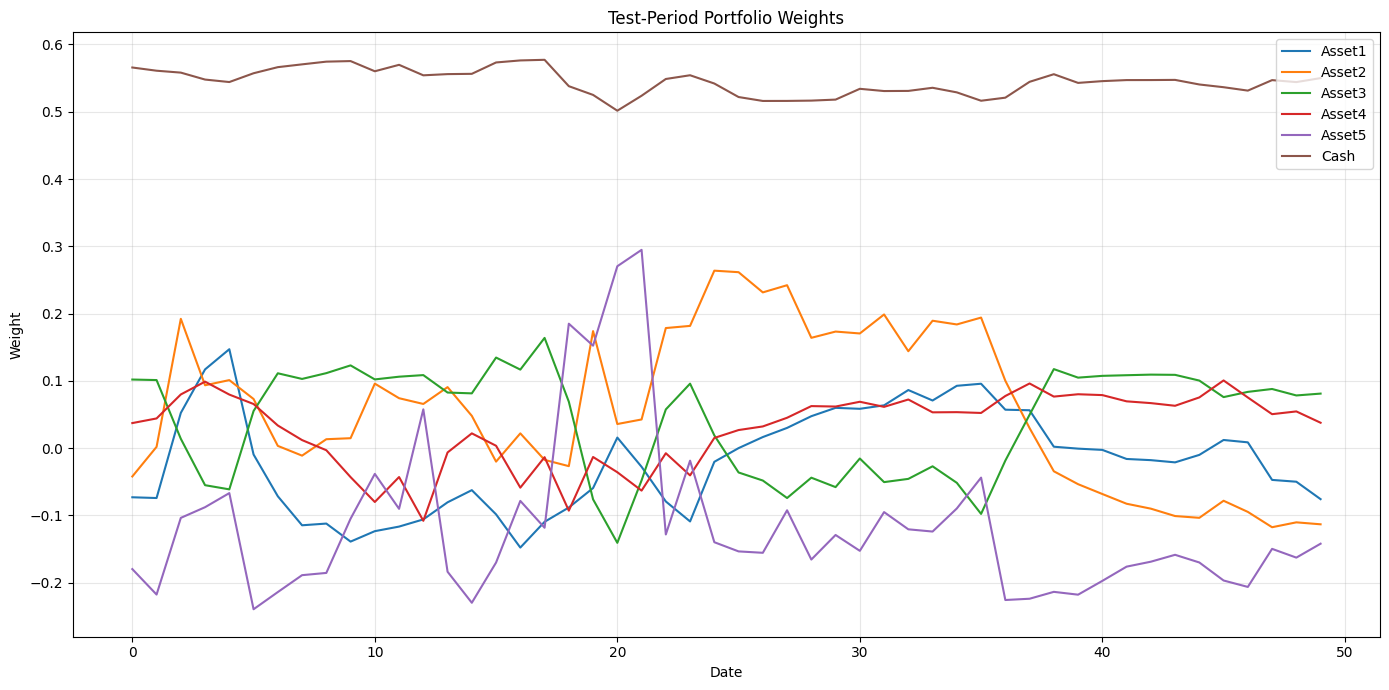

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# test_weights: shape (T_test, 6)
# test_dates:   index of length T_test

weight_cols = ["Asset1", "Asset2", "Asset3", "Asset4", "Asset5", "Cash"]

df_w = pd.DataFrame(test_weights[:50], columns=weight_cols)

plt.figure(figsize=(14, 7))
for col in df_w.columns:
    plt.plot(df_w.index, df_w[col], label=col)

plt.title("Test-Period Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [153]:
min(test_returns)

np.float32(-0.011670604)

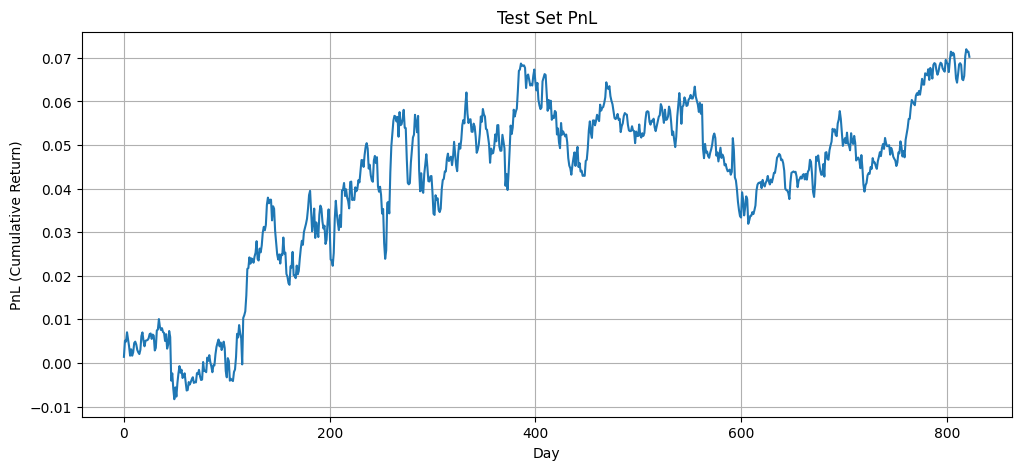

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose test_returns is a 1D numpy array of daily portfolio returns
test_returns = np.array(test_returns)

# Compute cumulative PnL (starting at 0 or starting at 1, choose one)
cumulative_pnl = np.cumprod(1 + test_returns) - 1  # cumulative return
# or:
# cumulative_pnl = np.cumsum(test_returns)          # raw PnL

plt.figure(figsize=(12,5))
plt.plot(cumulative_pnl)
plt.title("Test Set PnL")
plt.xlabel("Day")
plt.ylabel("PnL (Cumulative Return)")
plt.grid(True)
plt.show()
